In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.8/8062.4 GB disk)


In [2]:
%%writefile data.yaml

path: /kaggle/input/tomato-leaf-diseases-detection-computer-vision
train: train/images
val: valid/images
test: test/images
names:
  0: Bacterial Spot
  1: Early Blight
  2: Healthy
  3: Late Blight
  4: Leaf Mold
  5: Target Spot 
  6: Black Spot
nc: 7

Writing data.yaml


In [3]:
!python train.py --img 640 --batch 16 --epochs 15 --data data.yaml --weights yolov5x.pt --cache 

2024-07-21 19:39:31.200535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 19:39:31.200641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 19:39:31.307759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimi

In [4]:
!python detect.py --source /kaggle/input/tomato-leaf-diseases-detection-computer-vision/test/images --img 640 --conf 0.25 --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/tomato-leaf-diseases-detection-computer-vision/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 322 layers, 86213788 parameters, 0 gradients, 203.9 GFLOPs
image 1/31 /kaggle/input/tomato-leaf-diseases-detection-computer-vision/test/images/IMG_0219_JPG.rf.c8d288f364390a28656a50ed7415713a.jpg: 640x640 1 Healthy, 72.3ms
image 2/31 /kaggle/input/tomato-leaf-diseases-detection-computer-vision/test/images/IMG_0233_

In [7]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [8]:

ROOT_DIR = '/kaggle/input/tomato-leaf-diseases-detection-computer-vision'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'
classes = ['Bacterial Spot', 'Early Blight','Healthy', 'Late Blight' , 'Leaf Mold', 'Target Spot' ,'Black Spot']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax


def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

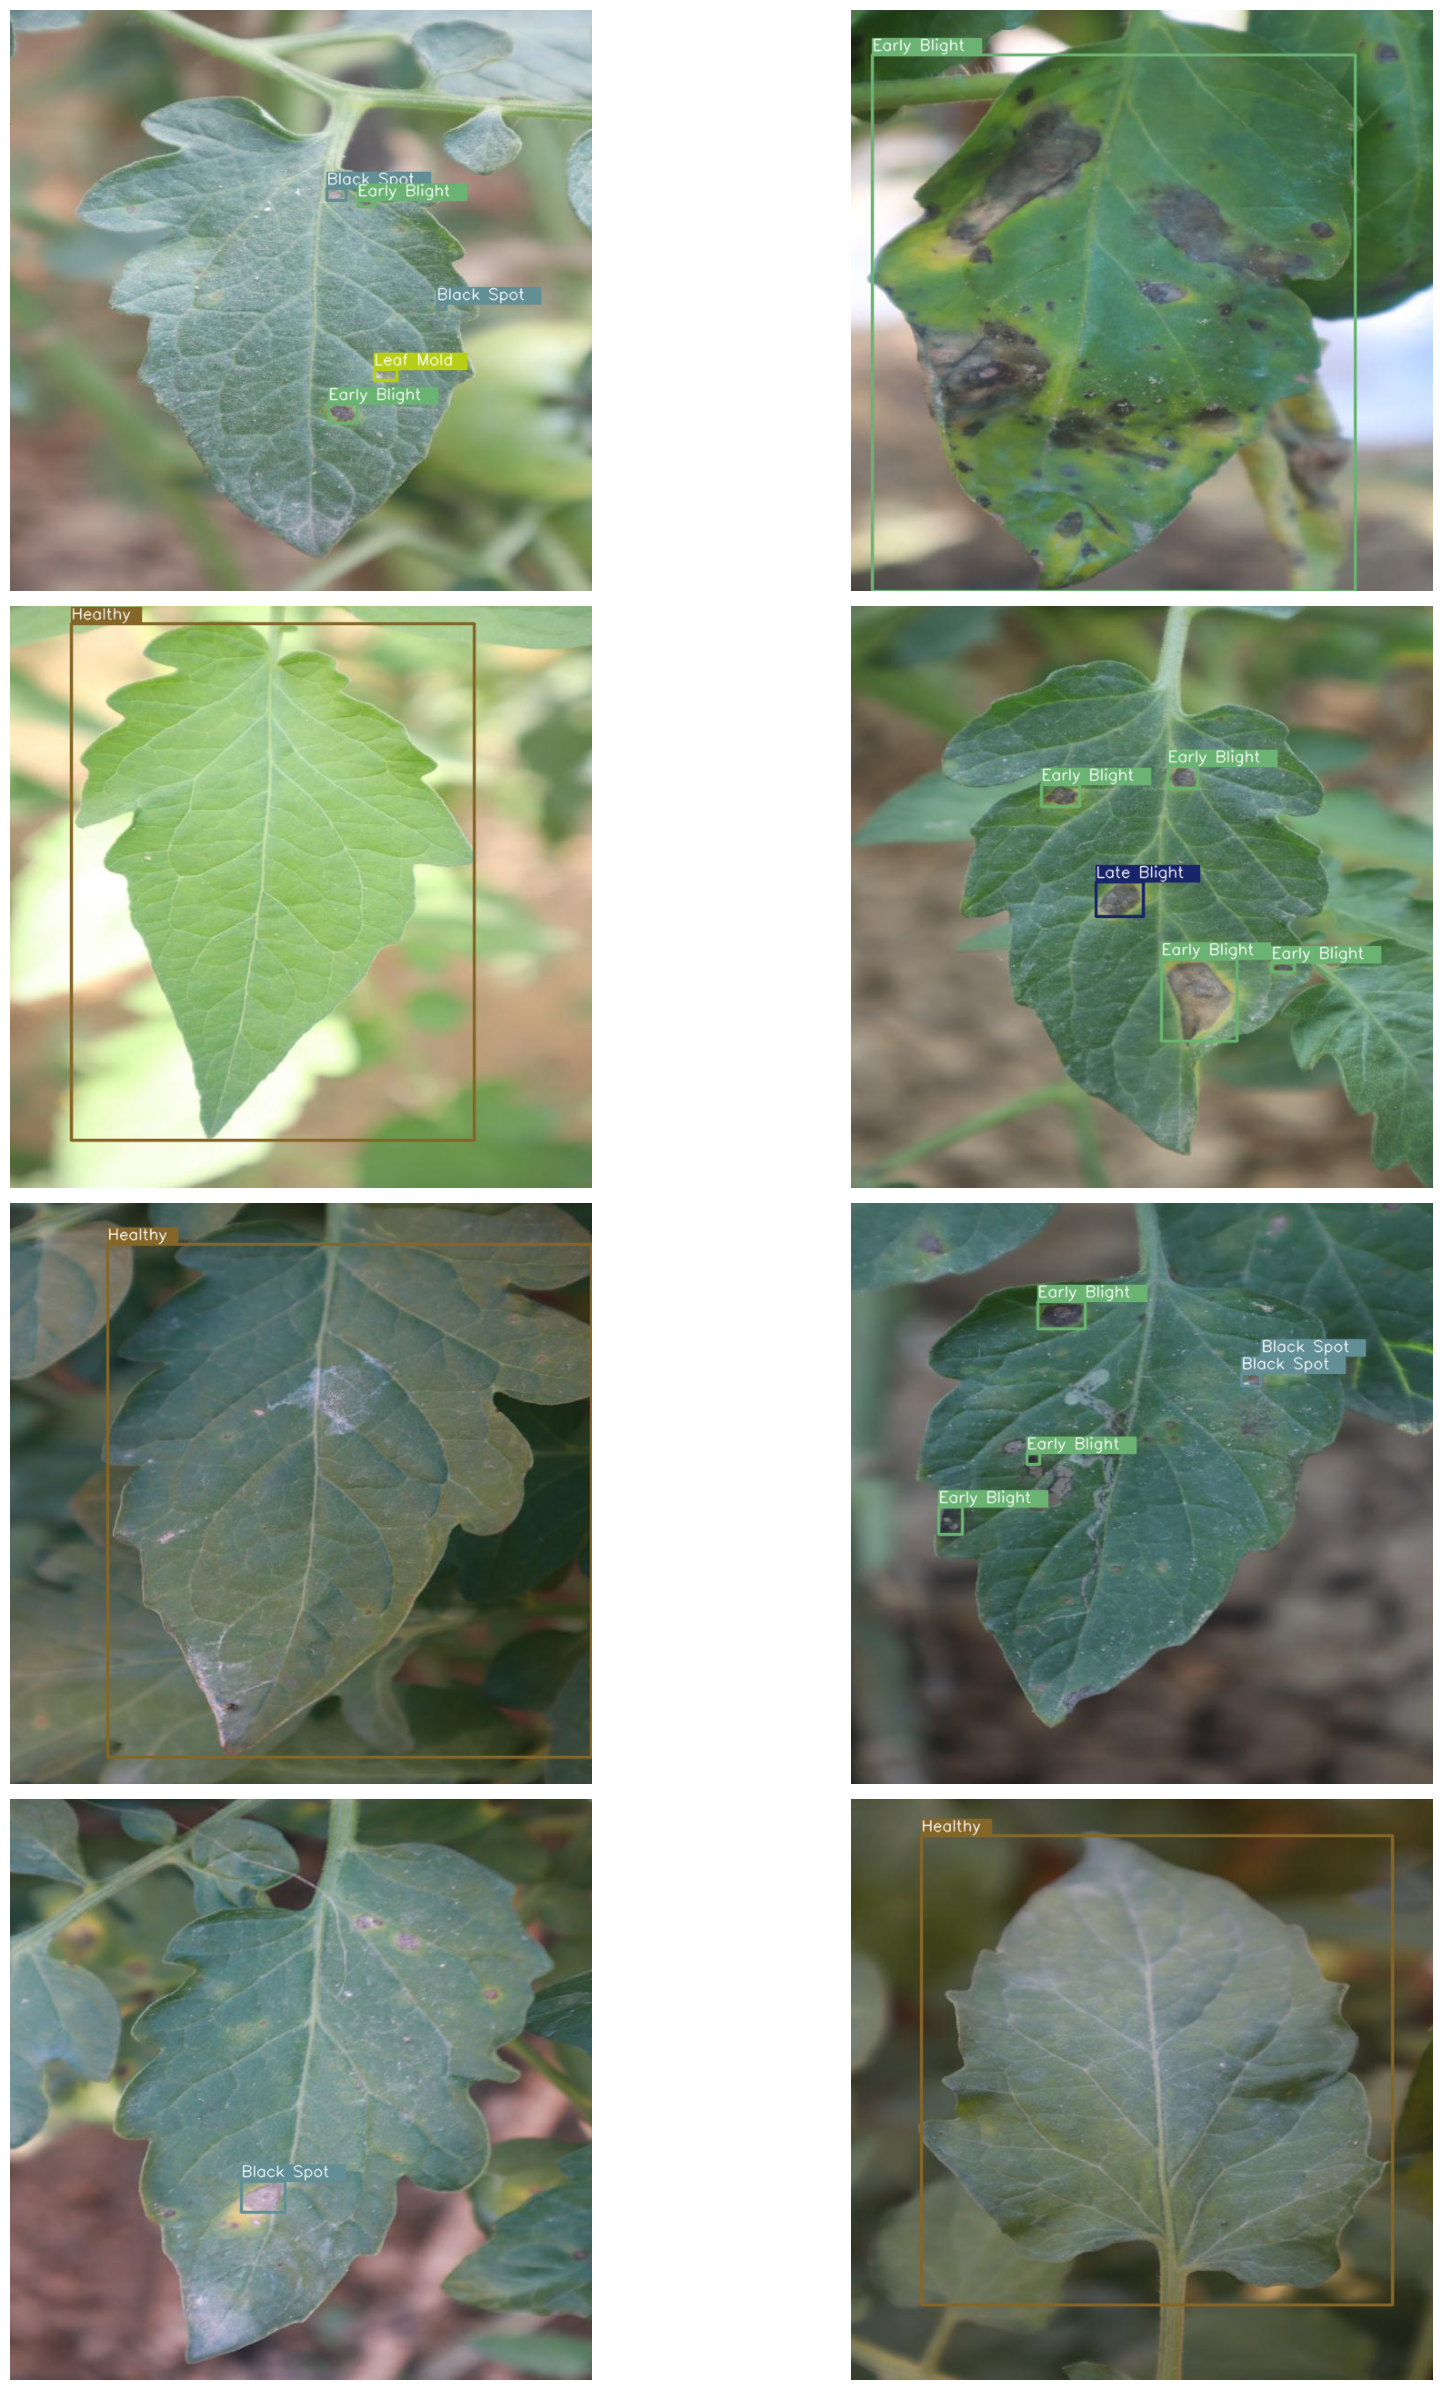

In [9]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [ ]:
from imutils import paths

log_dir = "/kaggle/working/yolov5/runs/detect/exp"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()